In [1]:
import src
import keras.backend as K
import os
import numpy as np
import sys
import re
import math
from functools import partial
import io
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings')

sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 532745748172351807
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4750075304075874050
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [28]:
def plot_advections(advected_aux_gen, advected_aux_truth, it):
    gen = advected_aux_gen[:5]
    truth =  advected_aux_truth[:5]
    fig, axs = plt.subplots(5, 2, figsize=(16, 16))
    for i in range(5):
        vmax = np.max([np.max(gen[i]), np.max(truth[i])])
        vmin = 0
        im = axs[i,0].imshow(gen[i, :,:,0], vmax=vmax,vmin=vmin)
        axs[i,0].axis('off')
        src.colorbar(im)
        axs[i,0].set_title("Advected generated frame")
        
        im = axs[i,1].imshow(truth[i, :,:,0], vmax=vmax,vmin=vmin)
        axs[i,1].axis('off')
        src.colorbar(im)
        axs[i,1].set_title("Advected reference frame")
        
    fig.savefig("Plots/advections_epoch %d.png" % it)
    plt.close()
    
class RandomWeightedAverage(keras.layers.Concatenate):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this outputs a random point on the line
    between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could think of.
    Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((batch_size, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1]) if len(inputs) == 2 else \
               [(weights * inputs[0]) + ((1 - weights) * inputs[1]), (weights * inputs[2]) + ((1 - weights) * inputs[3])]

In [3]:
past = 2
name = f"tgan_{past}-1"

Load dataset.

In [4]:
train, xval, test = src.load_datasets(past_frames=past+1)

Training data: (7500, 64, 64, 4)
Validation data: (1500, 64, 64, 4)
Test data: (1000, 64, 64, 4)


Split data to inputs and ground truth images.

In [5]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:2000], xval, test, past_frames=past+1, augment=True)

Data augmentation.
Shape of training data:  (8000, 64, 64, 3) 
Shape of training truth:  (8000, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 3) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 3) 
Shape of test truth:  (1000, 64, 64, 1)


Calculate optical flows between frame t-1 and t.

In [ ]:
#optical flow of the augmented data of the first 2000 training images (8000 images)
#vx, vy = src.optical_flow(gan_train[:,:,:,-2:-1], gan_train[:,:,:,-1:], window_size=4, tau=1e-2, init=1) # (n,:,:,1)

Save optical flows

In [ ]:
#np.savez_compressed(f"{name}_vx_2000",vx) #2000 denotes that they re the flo2 of the first 2000 samples from the training dataset
#np.savez_compressed(f"{name}_vy_2000",vy)

If optical flows are saved, load them

In [6]:
vx = np.load(sys.path[0]+f"/{name}_vx_2000.npz")["arr_0"]
vy = np.load(sys.path[0]+f"/{name}_vy_2000.npz")["arr_0"]

Preprocess optical flows

In [7]:
normalized_optical_flow = src.normalize_flows(vx, vy)


In [8]:
flows = np.transpose([[ndimage.median_filter(image[..., ch], 4) for ch in range(2)] for image in normalized_optical_flow], (0, 2, 3, 1))

Make discriminator labels.

In [9]:
batch_size=16
GRADIENT_PENALTY_WEIGHT = 10

Make generator but don't compile.

In [10]:
generator = src.unet((64, 64, past), dropout=0, batchnorm=True, kernel_size=4, feature_mult=1)

Make discriminators and compile.

In [11]:
s_discriminator = src.spatial_discriminator(condition_shape=(64, 64, past), dropout = 0.25, batchnorm=True, wgan=True)
#s_discriminator.compile(loss=src.wasserstein_loss,
#                        optimizer=keras.optimizers.RMSprop(lr=0.00005))

In [12]:
t_discriminator = src.temporal_discriminator(dropout = 0.25, batchnorm=True, wgan=True)
#t_discriminator.compile(loss=src.wasserstein_loss,
#                        optimizer=keras.optimizers.RMSprop(lr=0.00005))

Inputs and outputs of the GAN.

In [13]:
frame_t = keras.layers.Input(shape=(64, 64, past), name='input_condition_')
adv = keras.layers.Input(shape=(64, 64, 1), name="advected_frame")

In [14]:
generated = generator(frame_t)
s_score_fake = s_discriminator([frame_t, generated])
t_score_fake = t_discriminator([adv, generated])

Freeze discriminator weights.

In [15]:
s_discriminator.trainable = False
t_discriminator.trainable = False

Compile combined model.

In [16]:
loss_weights=[0, 1, 1]

In [17]:
combined = keras.models.Model(inputs=[frame_t, adv], outputs=[generated, s_score_fake, t_score_fake], name="combined_model")

In [18]:
combined.compile(loss=[src.custom_loss(loss="l1"),
                       src.wasserstein_loss,
                       src.wasserstein_loss],
                 optimizer=keras.optimizers.RMSprop(lr=0.00005),
                 loss_weights=loss_weights)

***Using L1 loss.***


Make gradient penalty

In [19]:
for l in s_discriminator.layers:
    l.trainable = True
for l in t_discriminator.layers:
    l.trainable = True
for l in generator.layers:
    l.trainable = False

s_discriminator.trainable = True
t_discriminator.trainable = True
generator.trainable = False

Inputs and outputs

In [20]:
real_samples = keras.layers.Input(shape=(64, 64, 1), name="ground_truth")
adv_real = keras.layers.Input(shape=(64, 64, 1), name="real_advected")

frame_t = keras.layers.Input(shape=(64, 64, past), name="input_sequence")
adv = keras.layers.Input(shape=(64, 64, 1), name="fake_advected")

generated = generator(frame_t)

In [21]:
ds_output_generated = s_discriminator([frame_t, generated])
ds_output_real = s_discriminator([frame_t, real_samples])
s_averaged_samples = RandomWeightedAverage()([real_samples, generated])
ds_output_avg = s_discriminator([frame_t, s_averaged_samples])

dt_output_generated = t_discriminator([adv, generated])
dt_output_real = t_discriminator([adv_real, real_samples])
t_averaged_samples, t_averaged_advections = RandomWeightedAverage()([real_samples, generated, adv_real, adv])
dt_output_avg = t_discriminator([t_averaged_advections, t_averaged_samples])

Partial losses

In [22]:
s_partial_gp_loss = partial(src.gradient_penalty_loss,
                          averaged_samples=s_averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
s_partial_gp_loss.__name__ = 's_gradient_penalty' 

t_partial_gp_loss = partial(src.gradient_penalty_loss,
                          averaged_samples=t_averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
t_partial_gp_loss.__name__ = 't_gradient_penalty' 

Compile

In [23]:
Ds = keras.models.Model(inputs=[frame_t, real_samples],
                                   outputs=[ds_output_real,
                                            ds_output_generated,
                                            ds_output_avg])

Dt = keras.models.Model(inputs=[frame_t, real_samples, adv, adv_real],
                                   outputs=[dt_output_real,
                                            dt_output_generated,
                                            dt_output_avg])

In [24]:
Ds.compile(optimizer=keras.optimizers.RMSprop(lr=0.00005),
          loss=[src.wasserstein_loss, src.wasserstein_loss, s_partial_gp_loss])

Dt.compile(optimizer=keras.optimizers.RMSprop(lr=0.00005),
          loss=[src.wasserstein_loss, src.wasserstein_loss, t_partial_gp_loss])

Train x epochs.

In [25]:
RND = 777
np.random.seed(RND)
iterations = 5000
g = 1
nb_batches = int(gan_train.shape[0] / batch_size)
positive_y = np.ones((batch_size, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

In [26]:
log = {"g_loss":[],
       "ds_loss":[],
       "dt_loss":[],
       "ds_loss_real":[],
       "ds_loss_fake":[],
       "ds_loss_avg":[],
       'ds_loss_wgan':[],
       "dt_loss_real":[],
       "dt_loss_fake":[],
       "dt_loss_avg":[],
       'dt_loss_wgan':[]}


4901/0 [Ds loss real: -12.194808006286621 Ds loss fake: 5.225922584533691 Ds loss avg: 0.046401821076869965] 
4901/0 [Dt loss real: -18323.53515625 Dt loss fake: -14401.3515625 Dt loss avg: 25.626419067382812]
4901/1 [Ds loss real: -10.289533615112305 Ds loss fake: 4.532108306884766 Ds loss avg: 0.4814034104347229] 
4901/1 [Dt loss real: -16082.3837890625 Dt loss fake: -13595.404296875 Dt loss avg: 1.0899869203567505]
4901/2 [Ds loss real: -10.04623031616211 Ds loss fake: 5.477148056030273 Ds loss avg: 0.17444242537021637] 
4901/2 [Dt loss real: -13245.203125 Dt loss fake: -15023.201171875 Dt loss avg: 3.2348220348358154]
4901/3 [Ds loss real: -12.330862045288086 Ds loss fake: 8.388169288635254 Ds loss avg: 0.10845845192670822] 
4901/3 [Dt loss real: -17879.296875 Dt loss fake: -13492.19921875 Dt loss avg: 2.5892977714538574]
4901/4 [Ds loss real: -8.652181625366211 Ds loss fake: 8.67937183380127 Ds loss avg: 0.321225106716156] 
4901/4 [Dt loss real: -16830.3984375 Dt loss fake: -1372

4904/6 [Ds loss real: -10.377805709838867 Ds loss fake: 6.3685808181762695 Ds loss avg: 0.1371922641992569] 
4904/6 [Dt loss real: -17396.15625 Dt loss fake: -13035.06640625 Dt loss avg: 11.790226936340332]
4904/7 [Ds loss real: -9.775074005126953 Ds loss fake: 7.257636547088623 Ds loss avg: 0.05267469584941864] 
4904/7 [Dt loss real: -17903.97265625 Dt loss fake: -13112.8388671875 Dt loss avg: 262.781494140625]
4904/8 [Ds loss real: -10.711515426635742 Ds loss fake: 9.327561378479004 Ds loss avg: 0.13919977843761444] 
4904/8 [Dt loss real: -16004.919921875 Dt loss fake: -13165.869140625 Dt loss avg: 2079.79443359375]
4904/9 [Ds loss real: -9.05419921875 Ds loss fake: 9.75561809539795 Ds loss avg: 0.22836078703403473] 
4904/9 [Dt loss real: -14136.7236328125 Dt loss fake: -13320.666015625 Dt loss avg: 1176.462890625]
 4904 [G loss: [13726.87, 0.12939389, -8.6199, 13735.49]] 
 Ds: real loss: -9.05419921875, fake loss: 9.75561809539795, avg loss: 0.22836078703403473 
 Dt: real loss: -141

4908/1 [Ds loss real: -9.750263214111328 Ds loss fake: 6.77687931060791 Ds loss avg: 0.33027684688568115] 
4908/1 [Dt loss real: -11526.939453125 Dt loss fake: -14408.275390625 Dt loss avg: 19.063087463378906]
4908/2 [Ds loss real: -14.094734191894531 Ds loss fake: 10.71306324005127 Ds loss avg: 0.10613680630922318] 
4908/2 [Dt loss real: -11349.8583984375 Dt loss fake: -14881.0234375 Dt loss avg: 0.8014203906059265]
4908/3 [Ds loss real: -12.08355712890625 Ds loss fake: 8.158232688903809 Ds loss avg: 0.08424614369869232] 
4908/3 [Dt loss real: -16314.0087890625 Dt loss fake: -13561.9951171875 Dt loss avg: 31.75745391845703]
4908/4 [Ds loss real: -11.488525390625 Ds loss fake: 9.407360076904297 Ds loss avg: 0.1694638431072235] 
4908/4 [Dt loss real: -13881.587890625 Dt loss fake: -14089.19921875 Dt loss avg: 17.44200897216797]
4908/5 [Ds loss real: -9.511493682861328 Ds loss fake: 5.367734432220459 Ds loss avg: 0.18275713920593262] 
4908/5 [Dt loss real: -17740.4609375 Dt loss fake: -1

4911/7 [Ds loss real: -10.506084442138672 Ds loss fake: 11.194875717163086 Ds loss avg: 0.08666650950908661] 
4911/7 [Dt loss real: -12163.0302734375 Dt loss fake: -13732.0478515625 Dt loss avg: 22.681884765625]
4911/8 [Ds loss real: -9.401205062866211 Ds loss fake: 5.56652307510376 Ds loss avg: 0.3608427047729492] 
4911/8 [Dt loss real: -16574.5390625 Dt loss fake: -12473.390625 Dt loss avg: 23.458511352539062]
4911/9 [Ds loss real: -12.653538703918457 Ds loss fake: 9.24149227142334 Ds loss avg: 0.19259300827980042] 
4911/9 [Dt loss real: -10680.34765625 Dt loss fake: -13450.00390625 Dt loss avg: 0.9466134309768677]
 4911 [G loss: [14140.399, 0.12877217, -7.6298504, 14148.029]] 
 Ds: real loss: -12.653538703918457, fake loss: 9.24149227142334, avg loss: 0.19259300827980042 
 Dt: real loss: -10680.34765625, fake loss: -13450.00390625, avg loss: 0.9466134309768677
4912/0 [Ds loss real: -9.303077697753906 Ds loss fake: 8.115272521972656 Ds loss avg: 0.19285324215888977] 
4912/0 [Dt loss 

4915/2 [Ds loss real: -9.060461044311523 Ds loss fake: 6.526495456695557 Ds loss avg: 0.14671477675437927] 
4915/2 [Dt loss real: -17506.87109375 Dt loss fake: -11420.361328125 Dt loss avg: 1960.728759765625]
4915/3 [Ds loss real: -10.731433868408203 Ds loss fake: 5.464343070983887 Ds loss avg: 0.18706992268562317] 
4915/3 [Dt loss real: -13912.681640625 Dt loss fake: -13776.462890625 Dt loss avg: 6907.01025390625]
4915/4 [Ds loss real: -10.54417610168457 Ds loss fake: 7.588141441345215 Ds loss avg: 0.08236950635910034] 
4915/4 [Dt loss real: -16793.3515625 Dt loss fake: -14263.9765625 Dt loss avg: 3151.365234375]
4915/5 [Ds loss real: -8.949464797973633 Ds loss fake: 9.436455726623535 Ds loss avg: 0.18187646567821503] 
4915/5 [Dt loss real: -14469.7822265625 Dt loss fake: -14957.6337890625 Dt loss avg: 1490.3834228515625]
4915/6 [Ds loss real: -11.214921951293945 Ds loss fake: 6.019555568695068 Ds loss avg: 0.3487524688243866] 
4915/6 [Dt loss real: -11987.94921875 Dt loss fake: -1492

4918/8 [Ds loss real: -8.589021682739258 Ds loss fake: 5.547723293304443 Ds loss avg: 0.6384468078613281] 
4918/8 [Dt loss real: -11533.625 Dt loss fake: -14303.6259765625 Dt loss avg: 0.9878416061401367]
4918/9 [Ds loss real: -7.90224027633667 Ds loss fake: 6.988936424255371 Ds loss avg: 0.098207488656044] 
4918/9 [Dt loss real: -16864.3125 Dt loss fake: -14642.458984375 Dt loss avg: 17.92169189453125]
 4918 [G loss: [11905.962, 0.12203728, -8.826682, 11914.789]] 
 Ds: real loss: -7.90224027633667, fake loss: 6.988936424255371, avg loss: 0.098207488656044 
 Dt: real loss: -16864.3125, fake loss: -14642.458984375, avg loss: 17.92169189453125
4919/0 [Ds loss real: -8.266149520874023 Ds loss fake: 4.977173805236816 Ds loss avg: 0.12996840476989746] 
4919/0 [Dt loss real: -17162.19921875 Dt loss fake: -13228.755859375 Dt loss avg: 1.9933042526245117]
4919/1 [Ds loss real: -6.323417663574219 Ds loss fake: 3.896897077560425 Ds loss avg: 0.2353927195072174] 
4919/1 [Dt loss real: -17656.1562

4922/3 [Ds loss real: -8.3289213180542 Ds loss fake: 5.7706403732299805 Ds loss avg: 0.07564589381217957] 
4922/3 [Dt loss real: -14240.9111328125 Dt loss fake: -15008.568359375 Dt loss avg: 0.5098877549171448]
4922/4 [Ds loss real: -8.495675086975098 Ds loss fake: 4.3437604904174805 Ds loss avg: 0.1827143430709839] 
4922/4 [Dt loss real: -14818.5107421875 Dt loss fake: -13547.35546875 Dt loss avg: 0.7439222931861877]
4922/5 [Ds loss real: -4.9861159324646 Ds loss fake: 7.656108856201172 Ds loss avg: 0.1508825719356537] 
4922/5 [Dt loss real: -16994.81640625 Dt loss fake: -14342.76171875 Dt loss avg: 0.28676551580429077]
4922/6 [Ds loss real: -11.511072158813477 Ds loss fake: 6.582653999328613 Ds loss avg: 0.050482604652643204] 
4922/6 [Dt loss real: -18047.216796875 Dt loss fake: -13322.357421875 Dt loss avg: 1.2768921852111816]
4922/7 [Ds loss real: -10.83915901184082 Ds loss fake: 7.269575119018555 Ds loss avg: 0.13852210342884064] 
4922/7 [Dt loss real: -17113.2578125 Dt loss fake:

4925/9 [Ds loss real: -11.378337860107422 Ds loss fake: 8.391284942626953 Ds loss avg: 0.5276737213134766] 
4925/9 [Dt loss real: -15817.6416015625 Dt loss fake: -13252.095703125 Dt loss avg: 22.299480438232422]
 4925 [G loss: [13301.633, 0.12953378, -7.2414103, 13308.874]] 
 Ds: real loss: -11.378337860107422, fake loss: 8.391284942626953, avg loss: 0.5276737213134766 
 Dt: real loss: -15817.6416015625, fake loss: -13252.095703125, avg loss: 22.299480438232422
4926/0 [Ds loss real: -9.041373252868652 Ds loss fake: 6.593628883361816 Ds loss avg: 0.8673062920570374] 
4926/0 [Dt loss real: -16264.03515625 Dt loss fake: -15117.341796875 Dt loss avg: 40.69249725341797]
4926/1 [Ds loss real: -10.089593887329102 Ds loss fake: 4.767603874206543 Ds loss avg: 0.5807087421417236] 
4926/1 [Dt loss real: -17326.1875 Dt loss fake: -13461.470703125 Dt loss avg: 21.543394088745117]
4926/2 [Ds loss real: -11.947088241577148 Ds loss fake: 8.028820037841797 Ds loss avg: 0.0539591908454895] 
4926/2 [Dt l

4929/4 [Ds loss real: -11.926496505737305 Ds loss fake: 8.701529502868652 Ds loss avg: 0.08023130893707275] 
4929/4 [Dt loss real: -16099.75390625 Dt loss fake: -14299.630859375 Dt loss avg: 0.4951913356781006]
4929/5 [Ds loss real: -7.401282787322998 Ds loss fake: 6.644388198852539 Ds loss avg: 0.24176406860351562] 
4929/5 [Dt loss real: -17480.01171875 Dt loss fake: -12251.1484375 Dt loss avg: 11.183491706848145]
4929/6 [Ds loss real: -10.931334495544434 Ds loss fake: 7.682463645935059 Ds loss avg: 0.42740756273269653] 
4929/6 [Dt loss real: -14893.525390625 Dt loss fake: -13513.9580078125 Dt loss avg: 2.013875961303711]
4929/7 [Ds loss real: -10.530774116516113 Ds loss fake: 7.10012149810791 Ds loss avg: 0.2847578227519989] 
4929/7 [Dt loss real: -19056.359375 Dt loss fake: -13759.384765625 Dt loss avg: 1.271510124206543]
4929/8 [Ds loss real: -9.195686340332031 Ds loss fake: 8.808462142944336 Ds loss avg: 0.14863410592079163] 
4929/8 [Dt loss real: -17159.234375 Dt loss fake: -1405

 4932 [G loss: [14653.052, 0.12938264, -7.47351, 14660.525]] 
 Ds: real loss: -9.6005859375, fake loss: 7.598525047302246, avg loss: 0.22346678376197815 
 Dt: real loss: -13926.140625, fake loss: -13021.0126953125, avg loss: 429.094970703125
4933/0 [Ds loss real: -10.886213302612305 Ds loss fake: 7.693166255950928 Ds loss avg: 0.32414302229881287] 
4933/0 [Dt loss real: -15528.75390625 Dt loss fake: -12983.1923828125 Dt loss avg: 283.219970703125]
4933/1 [Ds loss real: -11.901240348815918 Ds loss fake: 5.028801918029785 Ds loss avg: 0.12380406260490417] 
4933/1 [Dt loss real: -11778.36328125 Dt loss fake: -13678.0576171875 Dt loss avg: 540.0440673828125]
4933/2 [Ds loss real: -11.402225494384766 Ds loss fake: 7.929486274719238 Ds loss avg: 0.2415621280670166] 
4933/2 [Dt loss real: -16876.57421875 Dt loss fake: -13926.0537109375 Dt loss avg: 1409.72705078125]
4933/3 [Ds loss real: -10.616636276245117 Ds loss fake: 8.04668140411377 Ds loss avg: 0.5205985307693481] 
4933/3 [Dt loss real:

4936/5 [Ds loss real: -11.384495735168457 Ds loss fake: 8.141788482666016 Ds loss avg: 0.07783478498458862] 
4936/5 [Dt loss real: -18215.56640625 Dt loss fake: -13787.376953125 Dt loss avg: 882.02392578125]
4936/6 [Ds loss real: -11.400304794311523 Ds loss fake: 7.555971145629883 Ds loss avg: 0.09539718925952911] 
4936/6 [Dt loss real: -17717.8671875 Dt loss fake: -11703.41796875 Dt loss avg: 8068.740234375]
4936/7 [Ds loss real: -11.336196899414062 Ds loss fake: 8.850512504577637 Ds loss avg: 0.08058521896600723] 
4936/7 [Dt loss real: -16784.14453125 Dt loss fake: -15184.46484375 Dt loss avg: 1408.1005859375]
4936/8 [Ds loss real: -10.191490173339844 Ds loss fake: 10.046402931213379 Ds loss avg: 0.11768409609794617] 
4936/8 [Dt loss real: -14560.7080078125 Dt loss fake: -14499.900390625 Dt loss avg: 7437.4423828125]
4936/9 [Ds loss real: -12.666391372680664 Ds loss fake: 7.789936065673828 Ds loss avg: 0.25723129510879517] 
4936/9 [Dt loss real: -11038.8095703125 Dt loss fake: -14905

4940/0 [Ds loss real: -11.175881385803223 Ds loss fake: 8.773313522338867 Ds loss avg: 0.4088607728481293] 
4940/0 [Dt loss real: -16408.283203125 Dt loss fake: -13459.994140625 Dt loss avg: 707.6723022460938]
4940/1 [Ds loss real: -12.021549224853516 Ds loss fake: 7.30942440032959 Ds loss avg: 0.504084587097168] 
4940/1 [Dt loss real: -17990.318359375 Dt loss fake: -15017.88671875 Dt loss avg: 1765.17724609375]
4940/2 [Ds loss real: -11.234648704528809 Ds loss fake: 9.349448204040527 Ds loss avg: 0.05965197831392288] 
4940/2 [Dt loss real: -8831.2734375 Dt loss fake: -15738.2333984375 Dt loss avg: 5.702070713043213]
4940/3 [Ds loss real: -10.38723087310791 Ds loss fake: 9.466224670410156 Ds loss avg: 0.17604869604110718] 
4940/3 [Dt loss real: -14265.9208984375 Dt loss fake: -14393.01953125 Dt loss avg: 4.868310928344727]
4940/4 [Ds loss real: -10.62578010559082 Ds loss fake: 8.650615692138672 Ds loss avg: 0.309966117143631] 
4940/4 [Dt loss real: -17581.919921875 Dt loss fake: -14399

4943/6 [Ds loss real: -12.559894561767578 Ds loss fake: 9.177258491516113 Ds loss avg: 0.16561159491539001] 
4943/6 [Dt loss real: -14441.98828125 Dt loss fake: -14832.0869140625 Dt loss avg: 41.304134368896484]
4943/7 [Ds loss real: -10.277083396911621 Ds loss fake: 8.142768859863281 Ds loss avg: 0.44105103611946106] 
4943/7 [Dt loss real: -12449.724609375 Dt loss fake: -15061.732421875 Dt loss avg: 0.46539944410324097]
4943/8 [Ds loss real: -12.191349983215332 Ds loss fake: 9.092977523803711 Ds loss avg: 0.12219376862049103] 
4943/8 [Dt loss real: -12424.6025390625 Dt loss fake: -15433.712890625 Dt loss avg: 22.77539825439453]
4943/9 [Ds loss real: -8.273530960083008 Ds loss fake: 5.1815595626831055 Ds loss avg: 0.24344384670257568] 
4943/9 [Dt loss real: -16169.306640625 Dt loss fake: -15440.29296875 Dt loss avg: 1.8803596496582031]
 4943 [G loss: [13783.426, 0.13123108, -8.368858, 13791.795]] 
 Ds: real loss: -8.273530960083008, fake loss: 5.1815595626831055, avg loss: 0.2434438467

4947/1 [Ds loss real: -11.543649673461914 Ds loss fake: 6.5568342208862305 Ds loss avg: 0.27610790729522705] 
4947/1 [Dt loss real: -15892.05859375 Dt loss fake: -14588.6416015625 Dt loss avg: 1.8831441402435303]
4947/2 [Ds loss real: -8.711514472961426 Ds loss fake: 7.511148452758789 Ds loss avg: 0.5184170007705688] 
4947/2 [Dt loss real: -11574.658203125 Dt loss fake: -13350.943359375 Dt loss avg: 3.0188024044036865]
4947/3 [Ds loss real: -11.993856430053711 Ds loss fake: 7.898190021514893 Ds loss avg: 0.14460045099258423] 
4947/3 [Dt loss real: -14776.34375 Dt loss fake: -15095.8486328125 Dt loss avg: 3.068415641784668]
4947/4 [Ds loss real: -10.264554977416992 Ds loss fake: 8.481324195861816 Ds loss avg: 0.13799265027046204] 
4947/4 [Dt loss real: -13461.2509765625 Dt loss fake: -14628.734375 Dt loss avg: 16.76595687866211]
4947/5 [Ds loss real: -10.816265106201172 Ds loss fake: 7.249192714691162 Ds loss avg: 0.3105320930480957] 
4947/5 [Dt loss real: -14024.634765625 Dt loss fake:

4950/7 [Ds loss real: -11.44974136352539 Ds loss fake: 8.841327667236328 Ds loss avg: 0.15038618445396423] 
4950/7 [Dt loss real: -17648.75 Dt loss fake: -14222.259765625 Dt loss avg: 117.7268295288086]
4950/8 [Ds loss real: -10.659180641174316 Ds loss fake: 7.45267915725708 Ds loss avg: 0.2546612620353699] 
4950/8 [Dt loss real: -18632.38671875 Dt loss fake: -13909.5859375 Dt loss avg: 1.439990758895874]
4950/9 [Ds loss real: -12.610523223876953 Ds loss fake: 6.805384635925293 Ds loss avg: 0.09872835874557495] 
4950/9 [Dt loss real: -17268.6015625 Dt loss fake: -12753.373046875 Dt loss avg: 33.56766891479492]
 4950 [G loss: [13686.634, 0.13429579, -5.9158945, 13692.55]] 
 Ds: real loss: -12.610523223876953, fake loss: 6.805384635925293, avg loss: 0.09872835874557495 
 Dt: real loss: -17268.6015625, fake loss: -12753.373046875, avg loss: 33.56766891479492
4951/0 [Ds loss real: -13.536680221557617 Ds loss fake: 11.383964538574219 Ds loss avg: 0.14658060669898987] 
4951/0 [Dt loss real: 

4954/2 [Ds loss real: -12.954056739807129 Ds loss fake: 10.75228214263916 Ds loss avg: 0.04683134704828262] 
4954/2 [Dt loss real: -18178.93359375 Dt loss fake: -13786.4716796875 Dt loss avg: 27.991497039794922]
4954/3 [Ds loss real: -11.389408111572266 Ds loss fake: 11.146745681762695 Ds loss avg: 0.18351364135742188] 
4954/3 [Dt loss real: -14980.400390625 Dt loss fake: -14979.6435546875 Dt loss avg: 1.1249711513519287]
4954/4 [Ds loss real: -10.952821731567383 Ds loss fake: 9.402017593383789 Ds loss avg: 0.18532800674438477] 
4954/4 [Dt loss real: -18949.51953125 Dt loss fake: -12227.6083984375 Dt loss avg: 2.6871914863586426]
4954/5 [Ds loss real: -12.121416091918945 Ds loss fake: 8.354427337646484 Ds loss avg: 0.11246465146541595] 
4954/5 [Dt loss real: -16224.912109375 Dt loss fake: -14776.197265625 Dt loss avg: 2.509427070617676]
4954/6 [Ds loss real: -11.94263744354248 Ds loss fake: 7.050954341888428 Ds loss avg: 0.49349257349967957] 
4954/6 [Dt loss real: -19828.220703125 Dt l

4957/8 [Ds loss real: -11.559349060058594 Ds loss fake: 10.395393371582031 Ds loss avg: 0.3873792886734009] 
4957/8 [Dt loss real: -17713.197265625 Dt loss fake: -14957.7880859375 Dt loss avg: 5.573677062988281]
4957/9 [Ds loss real: -12.202133178710938 Ds loss fake: 9.754619598388672 Ds loss avg: 0.16951093077659607] 
4957/9 [Dt loss real: -19275.8359375 Dt loss fake: -12975.4921875 Dt loss avg: 5.637606620788574]
 4957 [G loss: [14204.517, 0.13657671, -8.062796, 14212.579]] 
 Ds: real loss: -12.202133178710938, fake loss: 9.754619598388672, avg loss: 0.16951093077659607 
 Dt: real loss: -19275.8359375, fake loss: -12975.4921875, avg loss: 5.637606620788574
4958/0 [Ds loss real: -13.958843231201172 Ds loss fake: 10.392751693725586 Ds loss avg: 0.19620263576507568] 
4958/0 [Dt loss real: -17803.15234375 Dt loss fake: -13563.2333984375 Dt loss avg: 2.067678689956665]
4958/1 [Ds loss real: -11.672419548034668 Ds loss fake: 8.452693939208984 Ds loss avg: 0.11620579659938812] 
4958/1 [Dt l

4961/3 [Ds loss real: -13.550186157226562 Ds loss fake: 9.373140335083008 Ds loss avg: 0.1300414502620697] 
4961/3 [Dt loss real: -14346.912109375 Dt loss fake: -15568.08984375 Dt loss avg: 322.6182861328125]
4961/4 [Ds loss real: -13.793384552001953 Ds loss fake: 8.806289672851562 Ds loss avg: 0.33475595712661743] 
4961/4 [Dt loss real: -14881.7138671875 Dt loss fake: -15329.0029296875 Dt loss avg: 19.827871322631836]
4961/5 [Ds loss real: -11.829296112060547 Ds loss fake: 10.601442337036133 Ds loss avg: 0.7715379595756531] 
4961/5 [Dt loss real: -14322.296875 Dt loss fake: -14968.3046875 Dt loss avg: 17.21571159362793]
4961/6 [Ds loss real: -11.214548110961914 Ds loss fake: 8.106331825256348 Ds loss avg: 0.18114900588989258] 
4961/6 [Dt loss real: -17560.001953125 Dt loss fake: -14674.79296875 Dt loss avg: 6.117763042449951]
4961/7 [Ds loss real: -10.542459487915039 Ds loss fake: 8.70190715789795 Ds loss avg: 0.26687851548194885] 
4961/7 [Dt loss real: -16482.23828125 Dt loss fake: -

4964/9 [Ds loss real: -11.673948287963867 Ds loss fake: 10.57737922668457 Ds loss avg: 0.06066577881574631] 
4964/9 [Dt loss real: -18978.3515625 Dt loss fake: -13196.3837890625 Dt loss avg: 2163.597412109375]
 4964 [G loss: [13437.934, 0.13919012, -10.152111, 13448.086]] 
 Ds: real loss: -11.673948287963867, fake loss: 10.57737922668457, avg loss: 0.06066577881574631 
 Dt: real loss: -18978.3515625, fake loss: -13196.3837890625, avg loss: 2163.597412109375
4965/0 [Ds loss real: -12.777090072631836 Ds loss fake: 7.4297380447387695 Ds loss avg: 0.11488181352615356] 
4965/0 [Dt loss real: -15976.72265625 Dt loss fake: -15065.75 Dt loss avg: 695.1436767578125]
4965/1 [Ds loss real: -12.68045425415039 Ds loss fake: 10.057130813598633 Ds loss avg: 0.16270460188388824] 
4965/1 [Dt loss real: -19467.353515625 Dt loss fake: -14428.568359375 Dt loss avg: 790.201904296875]
4965/2 [Ds loss real: -6.7176032066345215 Ds loss fake: 9.209077835083008 Ds loss avg: 0.22319620847702026] 
4965/2 [Dt loss

4968/4 [Ds loss real: -13.097870826721191 Ds loss fake: 10.786454200744629 Ds loss avg: 0.09976308047771454] 
4968/4 [Dt loss real: -18000.255859375 Dt loss fake: -13699.1328125 Dt loss avg: 1.131873369216919]
4968/5 [Ds loss real: -12.21116828918457 Ds loss fake: 7.829012870788574 Ds loss avg: 0.09563900530338287] 
4968/5 [Dt loss real: -19212.4140625 Dt loss fake: -11927.0234375 Dt loss avg: 30.704191207885742]
4968/6 [Ds loss real: -11.222100257873535 Ds loss fake: 10.541582107543945 Ds loss avg: 0.2353120893239975] 
4968/6 [Dt loss real: -16940.3125 Dt loss fake: -13905.9619140625 Dt loss avg: 62.48996353149414]
4968/7 [Ds loss real: -9.42143440246582 Ds loss fake: 7.802090644836426 Ds loss avg: 0.19997264444828033] 
4968/7 [Dt loss real: -19954.9375 Dt loss fake: -12306.8642578125 Dt loss avg: 557.8176879882812]
4968/8 [Ds loss real: -11.104049682617188 Ds loss fake: 9.497325897216797 Ds loss avg: 0.29971736669540405] 
4968/8 [Dt loss real: -18618.66796875 Dt loss fake: -13573.170

 4971 [G loss: [15242.427, 0.12674993, -10.136069, 15252.5625]] 
 Ds: real loss: -11.416914939880371, fake loss: 8.993949890136719, avg loss: 0.31420624256134033 
 Dt: real loss: -17873.41015625, fake loss: -11564.8818359375, avg loss: 1093.0491943359375
4972/0 [Ds loss real: -8.48033618927002 Ds loss fake: 5.658275604248047 Ds loss avg: 0.31046783924102783] 
4972/0 [Dt loss real: -17001.3046875 Dt loss fake: -15177.4130859375 Dt loss avg: 1199.97998046875]
4972/1 [Ds loss real: -9.23346996307373 Ds loss fake: 4.431082248687744 Ds loss avg: 0.33299607038497925] 
4972/1 [Dt loss real: -18050.11328125 Dt loss fake: -13727.626953125 Dt loss avg: 2081.138671875]
4972/2 [Ds loss real: -7.620377540588379 Ds loss fake: 8.602161407470703 Ds loss avg: 0.17867659032344818] 
4972/2 [Dt loss real: -16521.265625 Dt loss fake: -14339.3095703125 Dt loss avg: 21105.7890625]
4972/3 [Ds loss real: -10.301628112792969 Ds loss fake: 9.384007453918457 Ds loss avg: 0.1520366072654724] 
4972/3 [Dt loss real:

4975/5 [Ds loss real: -12.702791213989258 Ds loss fake: 5.128779411315918 Ds loss avg: 0.17965099215507507] 
4975/5 [Dt loss real: -19251.841796875 Dt loss fake: -13334.9404296875 Dt loss avg: 10.105061531066895]
4975/6 [Ds loss real: -12.415802001953125 Ds loss fake: 8.2850341796875 Ds loss avg: 0.4569537341594696] 
4975/6 [Dt loss real: -18142.150390625 Dt loss fake: -14298.0234375 Dt loss avg: 0.38642558455467224]
4975/7 [Ds loss real: -12.416826248168945 Ds loss fake: 11.257356643676758 Ds loss avg: 0.15796144306659698] 
4975/7 [Dt loss real: -16854.2421875 Dt loss fake: -15486.873046875 Dt loss avg: 4.559995174407959]
4975/8 [Ds loss real: -11.006645202636719 Ds loss fake: 10.041267395019531 Ds loss avg: 0.17404787242412567] 
4975/8 [Dt loss real: -17941.66796875 Dt loss fake: -15064.8857421875 Dt loss avg: 13.274747848510742]
4975/9 [Ds loss real: -14.144977569580078 Ds loss fake: 9.425458908081055 Ds loss avg: 0.3859023451805115] 
4975/9 [Dt loss real: -19200.57421875 Dt loss fa

4979/0 [Ds loss real: -10.173534393310547 Ds loss fake: 7.5883283615112305 Ds loss avg: 0.20691944658756256] 
4979/0 [Dt loss real: -16581.90625 Dt loss fake: -11392.484375 Dt loss avg: 6.1434431076049805]
4979/1 [Ds loss real: -11.009689331054688 Ds loss fake: 7.786957740783691 Ds loss avg: 0.29586219787597656] 
4979/1 [Dt loss real: -14686.2314453125 Dt loss fake: -12517.44140625 Dt loss avg: 2.9145991802215576]
4979/2 [Ds loss real: -10.294110298156738 Ds loss fake: 8.546463966369629 Ds loss avg: 0.17512163519859314] 
4979/2 [Dt loss real: -19550.443359375 Dt loss fake: -11978.775390625 Dt loss avg: 45.105438232421875]
4979/3 [Ds loss real: -11.536555290222168 Ds loss fake: 8.186535835266113 Ds loss avg: 0.7409037351608276] 
4979/3 [Dt loss real: -15101.974609375 Dt loss fake: -14676.6337890625 Dt loss avg: 65.80870056152344]
4979/4 [Ds loss real: -10.059000015258789 Ds loss fake: 9.45272159576416 Ds loss avg: 0.14434610307216644] 
4979/4 [Dt loss real: -18419.5 Dt loss fake: -13834

4982/6 [Ds loss real: -10.980955123901367 Ds loss fake: 5.881969451904297 Ds loss avg: 0.11701896786689758] 
4982/6 [Dt loss real: -16604.64453125 Dt loss fake: -15651.287109375 Dt loss avg: 5990.359375]
4982/7 [Ds loss real: -8.713098526000977 Ds loss fake: 9.092484474182129 Ds loss avg: 0.260173499584198] 
4982/7 [Dt loss real: -18105.33984375 Dt loss fake: -16442.02734375 Dt loss avg: 47.5894889831543]
4982/8 [Ds loss real: -10.999727249145508 Ds loss fake: 7.653884410858154 Ds loss avg: 0.29952219128608704] 
4982/8 [Dt loss real: -11480.083984375 Dt loss fake: -14905.5419921875 Dt loss avg: 124.80487823486328]
4982/9 [Ds loss real: -11.351313591003418 Ds loss fake: 7.819967269897461 Ds loss avg: 0.1817413568496704] 
4982/9 [Dt loss real: -15158.53515625 Dt loss fake: -15583.06640625 Dt loss avg: 5.1219482421875]
 4982 [G loss: [15983.274, 0.13285972, -8.571539, 15991.846]] 
 Ds: real loss: -11.351313591003418, fake loss: 7.819967269897461, avg loss: 0.1817413568496704 
 Dt: real lo

4986/1 [Ds loss real: -11.102516174316406 Ds loss fake: 8.81363296508789 Ds loss avg: 0.1844990849494934] 
4986/1 [Dt loss real: -17539.291015625 Dt loss fake: -13375.080078125 Dt loss avg: 26.322853088378906]
4986/2 [Ds loss real: -10.83854866027832 Ds loss fake: 7.48849630355835 Ds loss avg: 0.26450544595718384] 
4986/2 [Dt loss real: -19138.3046875 Dt loss fake: -14437.51171875 Dt loss avg: 19.109405517578125]
4986/3 [Ds loss real: -9.03333854675293 Ds loss fake: 9.565435409545898 Ds loss avg: 0.3962283134460449] 
4986/3 [Dt loss real: -18190.6875 Dt loss fake: -14619.611328125 Dt loss avg: 25.463672637939453]
4986/4 [Ds loss real: -10.16359806060791 Ds loss fake: 8.136299133300781 Ds loss avg: 0.5682030320167542] 
4986/4 [Dt loss real: -19037.294921875 Dt loss fake: -14479.69921875 Dt loss avg: 296.795654296875]
4986/5 [Ds loss real: -8.309307098388672 Ds loss fake: 5.366710662841797 Ds loss avg: 0.4889770448207855] 
4986/5 [Dt loss real: -16737.05859375 Dt loss fake: -15336.845703

4989/7 [Ds loss real: -10.043288230895996 Ds loss fake: 7.154953956604004 Ds loss avg: 0.2563418745994568] 
4989/7 [Dt loss real: -9034.9482421875 Dt loss fake: -16134.84765625 Dt loss avg: 360.40826416015625]
4989/8 [Ds loss real: -9.446819305419922 Ds loss fake: 7.5052080154418945 Ds loss avg: 0.21065446734428406] 
4989/8 [Dt loss real: -18056.400390625 Dt loss fake: -15828.126953125 Dt loss avg: 644.0347900390625]
4989/9 [Ds loss real: -9.591115951538086 Ds loss fake: 9.798184394836426 Ds loss avg: 0.07450682669878006] 
4989/9 [Dt loss real: -13395.76171875 Dt loss fake: -15553.19140625 Dt loss avg: 431.7890625]
 4989 [G loss: [14626.892, 0.13928896, -7.8210325, 14634.713]] 
 Ds: real loss: -9.591115951538086, fake loss: 9.798184394836426, avg loss: 0.07450682669878006 
 Dt: real loss: -13395.76171875, fake loss: -15553.19140625, avg loss: 431.7890625
4990/0 [Ds loss real: -9.932312965393066 Ds loss fake: 8.34243392944336 Ds loss avg: 0.3144611716270447] 
4990/0 [Dt loss real: -1443

4993/2 [Ds loss real: -13.097122192382812 Ds loss fake: 8.348365783691406 Ds loss avg: 0.18115168809890747] 
4993/2 [Dt loss real: -17116.33984375 Dt loss fake: -15259.5224609375 Dt loss avg: 0.418429970741272]
4993/3 [Ds loss real: -13.234264373779297 Ds loss fake: 9.923639297485352 Ds loss avg: 0.0690096840262413] 
4993/3 [Dt loss real: -19672.826171875 Dt loss fake: -14168.0439453125 Dt loss avg: 8.613065719604492]
4993/4 [Ds loss real: -12.188175201416016 Ds loss fake: 8.325501441955566 Ds loss avg: 0.17249955236911774] 
4993/4 [Dt loss real: -19012.984375 Dt loss fake: -14236.7392578125 Dt loss avg: 0.5725115537643433]
4993/5 [Ds loss real: -9.792570114135742 Ds loss fake: 6.079116344451904 Ds loss avg: 0.1652546525001526] 
4993/5 [Dt loss real: -19503.302734375 Dt loss fake: -14678.515625 Dt loss avg: 3.480989456176758]
4993/6 [Ds loss real: -10.298173904418945 Ds loss fake: 9.63851547241211 Ds loss avg: 0.2892880141735077] 
4993/6 [Dt loss real: -17908.611328125 Dt loss fake: -1

4996/8 [Ds loss real: -11.0244779586792 Ds loss fake: 8.233512878417969 Ds loss avg: 0.2071901559829712] 
4996/8 [Dt loss real: -16744.7890625 Dt loss fake: -16517.216796875 Dt loss avg: 11934.486328125]
4996/9 [Ds loss real: -10.892354965209961 Ds loss fake: 7.574301719665527 Ds loss avg: 0.5975462794303894] 
4996/9 [Dt loss real: -13609.8046875 Dt loss fake: -15578.08984375 Dt loss avg: 1245.18603515625]
 4996 [G loss: [15222.565, 0.1320363, -11.923264, 15234.488]] 
 Ds: real loss: -10.892354965209961, fake loss: 7.574301719665527, avg loss: 0.5975462794303894 
 Dt: real loss: -13609.8046875, fake loss: -15578.08984375, avg loss: 1245.18603515625
4997/0 [Ds loss real: -11.95816421508789 Ds loss fake: 9.72355842590332 Ds loss avg: 0.16347770392894745] 
4997/0 [Dt loss real: -13209.482421875 Dt loss fake: -14978.296875 Dt loss avg: 124.11654663085938]
4997/1 [Ds loss real: -12.966925621032715 Ds loss fake: 10.115148544311523 Ds loss avg: 0.3989819288253784] 
4997/1 [Dt loss real: -1274

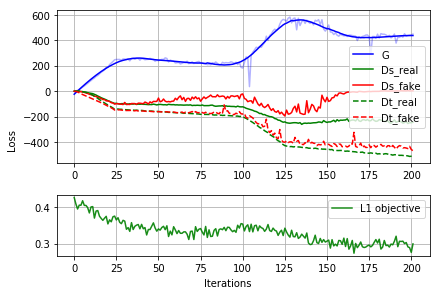

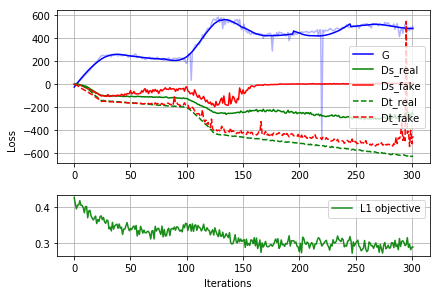

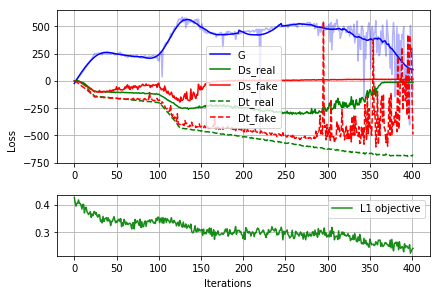

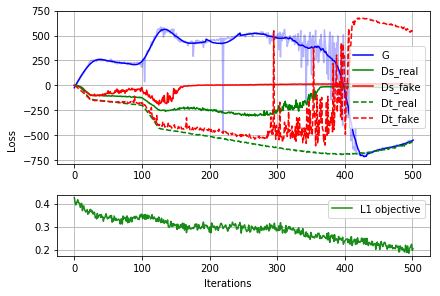

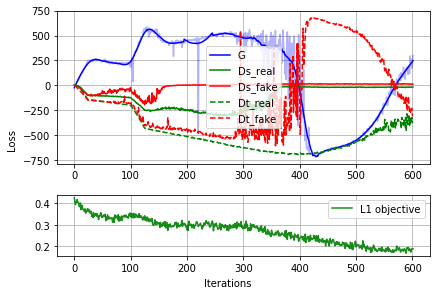

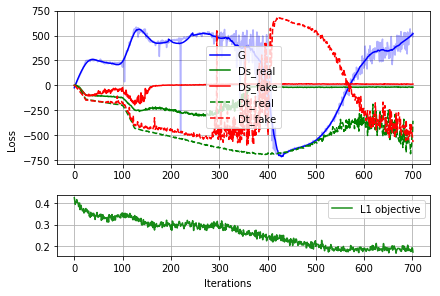

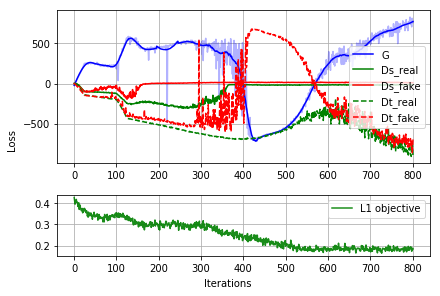

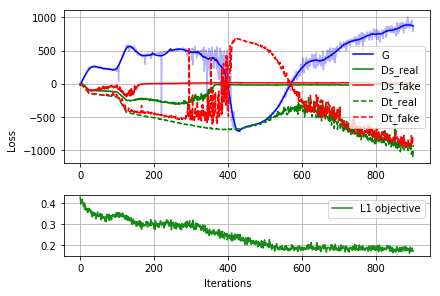

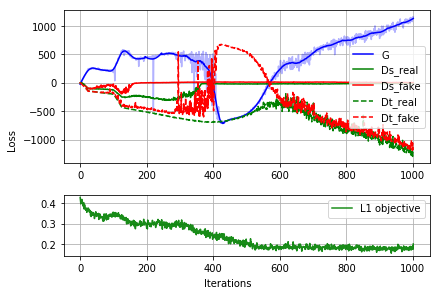

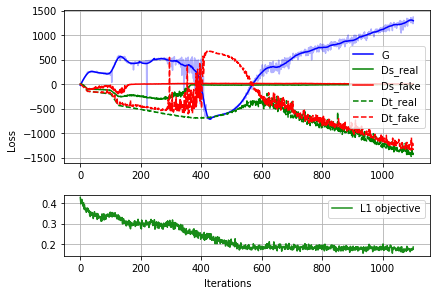

In [ ]:
for it in range(iterations):
#batch
#idx = range(it%nb_batches * batch_size,(it%nb_batches + 1) * batch_size)
    if (it % 1000) < 25 or it % 500 == 0: # 25 times in 1000, every 500th
        d_iters = 100
    else:
        d_iters = 10
        
    s_discriminator.trainable = True
    for l in s_discriminator.layers: l.trainable = True
    t_discriminator.trainable = True
    for l in t_discriminator.layers: l.trainable = True
    generator.trainable = False
    for l in generator.layers: l.trainable = False
            
    for d_it in range(d_iters):
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        
        ds_loss = Ds.train_on_batch([training_batch, real_imgs], [negative_y, positive_y, dummy_y])
    
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        aux_batch = gan_train[idx,:,:,:-1]
            
        advected_aux_gen = generator.predict(aux_batch)
        advected_aux_truth = training_batch[:,:,:,-1:]
        for i in range(10):
            advected_aux_gen = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected_aux_gen, -flows[idx]), axis=-1)])
            advected_aux_truth = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected_aux_truth, -flows[idx]), axis=-1)])
        
        dt_loss = Dt.train_on_batch([training_batch,
                                     real_imgs,
                                     advected_aux_gen,
                                     advected_aux_truth], [negative_y, positive_y, dummy_y])
        
        print(f"{it}/{d_it} [Ds loss real: {ds_loss[1]} Ds loss fake: {ds_loss[2]} Ds loss avg: {ds_loss[3]}] \n"+
              f"{it}/{d_it} [Dt loss real: {dt_loss[1]} Dt loss fake: {dt_loss[2]} Dt loss avg: {dt_loss[3]}]")

#Generator
    s_discriminator.trainable = False
    for l in s_discriminator.layers: l.trainable = False
    t_discriminator.trainable = False
    for l in t_discriminator.layers: l.trainable = False
    generator.trainable = True
    for l in generator.layers: l.trainable = True
        
    for tg in range(g):
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        aux_batch = gan_train[idx,:,:,:-1]

        advected = generator.predict(aux_batch)
        for i in range(10):
            advected = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected, -flows[idx]), axis=-1)])  
    
        g_loss = combined.train_on_batch([training_batch, advected], [real_imgs, negative_y, negative_y])
    
    log["g_loss"].append(g_loss)
    log["ds_loss"].append(ds_loss) 
    log["dt_loss"].append(dt_loss)
    log["ds_loss_real"].append(ds_loss[1])
    log["ds_loss_fake"].append(ds_loss[2])
    log["ds_loss_avg"].append(ds_loss[3])
    log['ds_loss_wgan'].append(-1 * ds_loss[1] + ds_loss[2])
    log["dt_loss_real"].append(dt_loss[1])
    log["dt_loss_fake"].append(dt_loss[2])
    log["dt_loss_avg"].append(dt_loss[3])
    log['dt_loss_wgan'].append(-1 * dt_loss[1] + dt_loss[2])
    
    
    print(f"\033[1m {it} [G loss: {g_loss}]\033[0m \n"+
          f" Ds: real loss: {ds_loss[1]}, fake loss: {ds_loss[2]}, avg loss: {ds_loss[3]} \n"+
          f" Dt: real loss: {dt_loss[1]}, fake loss: {dt_loss[2]}, avg loss: {dt_loss[3]}")
    if it%100 == 0 and it>0:
        src.sample_images(it, gan_test[...,1:], gan_test_truth, past, generator)
        plot_advections(advected_aux_gen, advected_aux_truth, it)
        src.plot_temporal_training_curves(log, it, name, wgan=True)
        src.update_output("")

src.sample_images(iterations, gan_test[...,1:], gan_test_truth, past, generator)
src.plot_temporal_training_curves(log, iterations, name, wgan=True)

In [ ]:
src.plot_temporal_training_curves(log, iterations, name, wgan=True)

In [ ]:
total_g_loss = np.array(log["g_loss"])[:,0]
total_d_loss = np.array(log["d_loss"])[:,0]
smoothed_tgl = src.smooth(np.array(log["g_loss"])[:,0])
smoothed_tdl = src.smooth(np.array(log["d_loss"])[:,0])
objective_loss = np.array(log["g_loss"])[:,1]

# plot 'em
f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 2]})
a0.plot(total_g_loss, alpha=0.3, c="b")
a0.plot(total_d_loss, alpha=0.3, c="orange")
a0.plot(smoothed_tgl, c="b", label="generator")
a0.grid()
a0.plot(smoothed_tdl, c="orange", label="discriminator")
a0.legend()
a1.plot(objective_loss, alpha=0.9, c="green", label="L1 objective")
a1.grid()
a1.legend()
f.text(0.5, 0, 'Iterations', ha='center', va='center')
f.text(0, 0.5, 'Loss', ha='center', va='center', rotation='vertical')

f.tight_layout()
f.savefig(name+'_curves.png')

## Save features

Save model history

In [ ]:
np.save(name+"_log",log)

Save model weights

In [ ]:
combined.save_weights(name+"_model.h5")

Load model and predict

In [ ]:
combined.load_weights(sys.path[1]+"/"+name+"/"+name+"_model.h5")

Predict future frames. Loads a 20 long sequence with 1000 sequence samples.

In [ ]:
sequence_test = src.load_datasets(prediction=True)

In [ ]:
sequence_test = src.augment_data(sequence_test[:100])

In [ ]:
sequence_test.shape

In [ ]:
generator = combined.layers[1]

In [ ]:
#test
predictions = {}
past_frames = sequence_test[...,0:past]
test_truth = sequence_test[...,past:past+1]
for t in range(5):
    future = generator.predict(past_frames, batch_size=64)
    predictions[f"{t}"] = future
    past_frames = np.concatenate((past_frames[:,:,:,1:], predictions[f"{t}"]), axis=-1)
    test_truth = sequence_test[...,past+1+t:past+2+t]

Save example predictions

In [ ]:
def save_examples(name, test, predictions_dict, past, samples=0):
    fig, axs = plt.subplots(len(samples)*2,past+len(predictions_dict.keys()), figsize=(32, 32))
    fig.subplots_adjust(wspace=0.3, hspace=0.0)
    for n in range(len(samples)):
        vmax = np.max(test[n,:,:,:past])
        vmin = 0
        print(test.shape)
        for i in range(past):
            im = axs[2*n,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
        for i in range(past,past+len(predictions_dict.keys())):
            im = axs[2*n,i].imshow(predictions_dict[f"{i-past}"][samples[n], :,:,0], vmax=vmax, vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Predicted frame {i-past+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax, vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Reference frame {i-past+1}")
            src.colorbar(im)
    fig.savefig(f"Plots/{name}_sequence_prediction.png")
    plt.close()


In [ ]:
save_examples(name, sequence_test, predictions, past, samples=[33])

Renormalize intensity values

In [ ]:
norms = np.load(sys.path[0]+"/5min_norms_compressed.npz")["arr_1"]

In [ ]:
# *4 bc of augmentaion (it concats the frames so the 0th 1000th 2000th and 3000th are the same sample just rotated)
test_norms = list(norms[9000:])*4

In [ ]:
#renormalize test samples
renormalized_test = np.array([sample * np.array(test_norms)[i] for i, sample in enumerate(sequence_test)])
renormalized_predictions = np.transpose((np.array([[sample * np.array(test_norms)[i] for i, sample in enumerate(predictions[key])] for key in ['0', '1', '2', '3']])[:,:,:,:,0]), (1,2,3,0))

Calculate pixel intensities back to dBZ and from there to mm/h. <br>
Sources: <br>
- https://www.dwd.de/DE/leistungen/radolan/radolan_info/radolan_radvor_op_komposit_format_pdf.pdf?__blob=publicationFile&v=11 (page 10)
- <https://web.archive.org/web/20160113151652/http://www.desktopdoppler.com/help/nws-nexrad.htm#rainfall%20rates>

In [ ]:
#dBZ
dBZ_t = renormalized_test*0.5 - 32.5
dBZ_p = renormalized_predictions*0.5 - 32.5
#mm/h
I_t = (0.005*10**(0.1*dBZ_t))**(0.625)
I_p = (0.005*10**(0.1*dBZ_p))**(0.625)

In [ ]:
#thresholds: 2, 8, 42
thresholds = [0.5]
scores = {}
for t in range(I_t.shape[-1]): # loop over the predictions (4)
    for s in thresholds: # make a dict entry for each threshold score
        scores[f"pred_{t+1}"] = src.calculate_skill_scores(I_p[...,t:t+1],
                                                          I_t[...,past+t:past+1+t],
                                                          x=I_t[...,past-1:past],
                                                          threshold=s)

In [ ]:
scores["pred_1"].keys()

In [ ]:
np.save(name+"_scores",scores)

In [ ]:
name

In [ ]:
loaded_scores = np.load(sys.path[1]+"/"+name"/"+name+"_scores.npy").item()

In [ ]:
list(loaded_scores.keys())

In [ ]:
np.mean((pd.Series(scores["pred_2"]["corr_to_truth"]).dropna()))

In [ ]:
np.mean((pd.Series(scores["pred_2"]["corr_to_input"]).dropna()))

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_name = 'block5_conv3'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
K.mean(layer_output[:, :, :, filter_index])